In [1]:
import numpy as n
from matplotlib import pyplot as plt
import os
import numpy.lib.recfunctions as rfn
import copy

from sklearn.metrics import confusion_matrix

import torch
from torch import nn

In [2]:
import vame

In [3]:
import time

## Functions
#### Load data files
`data_root` should contain the root directory of the folder downloaded from Dropbox.

In [4]:
def load_data(data_root, dlc_dir, ann_dir, verbose=False):
    
    dlc_path = os.path.join(data_root, dlc_dir)
    ann_path = os.path.join(data_root, ann_dir)
    all_data = {}
    if verbose: print("Loading files: ")
    for f_name in os.listdir(dlc_path):
        if f_name[-3:] != 'npy':
            continue

        dlc_file=os.path.join(dlc_path, f_name)
        ann_file=os.path.join(ann_path, 'Annotated_' + f_name)
        if verbose: print("\t" + f_name + "\n\tAnnotated_" + f_name)
        data_dlc = n.load(dlc_file)
        data_ann = n.load(ann_file)
        labels = data_dlc[0]
        dtype = [('t', n.int), ('ann', 'U30')]
        i = 0
        for label in data_dlc[0]:
            i += 1
            coord = 'x' if i % 2 == 0 else 'y'
            dtype += [(label + '_' + coord , n.float32 )]

        data_concat = n.concatenate((data_ann, data_dlc[1:]),axis=1)
        data = n.array(n.zeros(data_concat.shape[0]), dtype = dtype)
        for i in range(data_concat.shape[1]):
            data[dtype[i][0]] = data_concat[:, i]
        all_data[f_name[:-4]] = data
    return all_data

#### Velocities

In [5]:
def dot(a, b):
    return n.sum(a * b, axis=-1)

def mag(a):
    return n.sqrt(n.sum(a*a, axis=-1))

def get_angle(a, b):
    cosab = dot(a, b) / (mag(a) * mag(b)) # cosine of angle between vectors
    angle = n.arccos(cosab) # what you currently have (absolute angle)

    b_t = b[:,[1,0]] * [1, -1] # perpendicular of b

    is_cc = dot(a, b_t) < 0

    # invert the angles for counter-clockwise rotations
    angle[is_cc] = 2*n.pi - angle[is_cc]
    return 360 - n.rad2deg(angle)

In [6]:
def calculate_velocity(trial):
    names = []; dtypes = []; datas = []
    velocities_calculated = []
    for label in trial.dtype.names:
        if label[-2:] in ['_x', '_y']:
            names.append(label+'_vel')  
            dtypes += [n.float]
            datas += [n.zeros(trial.shape[0])]
            velocities_calculated.append(label)
    trial = rfn.append_fields(trial, names, datas, dtypes)
    trial = n.array(trial, trial.dtype)
    for label in velocities_calculated:
        vel = n.gradient(trial[label])
        trial[label + '_vel'] = vel
    return trial
def normalize_trial(trial, feature_labels, nan = -10000, only_rat1 = False):
    ref_x = trial[feature_labels[1]].copy()
    ref_y = trial[feature_labels[0]].copy()
    for i,label in enumerate(feature_labels):
        if label[-1] == 'y':
    #         print('y-pre:',n.nanmax(features[:,i]))
            trial[label] -= ref_y
    #         print('y-post:', n.nanmax(features[:,i]))
        elif label[-1] == 'x':
    #         print('x-pre:',n.nanmax(features[:,i]))
            trial[label] -= ref_x
    #         print('x-post:', n.nanmax(features[:,i]))

    mouse_1_pos_labels = []
    mouse_2_pos_labels = []
    mouse_1_vel_labels = []
    mouse_2_vel_labels = []
    for label in feature_labels:
        if label[-3:] == 'vel':
            if label[-7] == '1':
                mouse_1_vel_labels.append(label)
            else:
                mouse_2_vel_labels.append(label)
        else:
            if label[-3] == '1':
                mouse_1_pos_labels.append(label)
            else:
                mouse_2_pos_labels.append(label)


    mouse_1_pos = n.zeros((len(mouse_1_pos_labels),len(trial)))
    for i,l in enumerate(mouse_1_pos_labels): mouse_1_pos[i]=trial[l]
    mouse_2_pos = n.zeros((len(mouse_2_pos_labels),len(trial)))
    for i,l in enumerate(mouse_2_pos_labels): mouse_2_pos[i]=trial[l]
    mouse_1_vel = n.zeros((len(mouse_1_vel_labels),len(trial)))
    for i,l in enumerate(mouse_1_vel_labels): mouse_1_vel[i]=trial[l]
    mouse_2_vel = n.zeros((len(mouse_2_vel_labels),len(trial)))
    for i,l in enumerate(mouse_2_vel_labels): mouse_2_vel[i]=trial[l]
    # TODO how to normalize??
    if not only_rat1:
        trial_data = n.concatenate([mouse_1_pos, mouse_2_pos, mouse_1_vel, mouse_2_vel])
        trial_labels = n.concatenate([mouse_1_pos_labels, mouse_2_pos_labels, mouse_1_vel_labels, mouse_2_vel_labels])
    else:
        trial_data = n.concatenate([mouse_1_pos, mouse_1_vel])
        trial_labels = n.concatenate([mouse_1_pos_labels, mouse_1_vel_labels])
    if nan is not None:
        trial_data = n.nan_to_num(trial_data, nan=nan)
    
    return trial_data, trial_labels

## Separate train, test and val sets

In [7]:
def split_sets(features_all,targets_all, chunk_size=500, splits= (0.7, 0.2, 0.1), separate_vid_idx = None):
    data_len = features_all.shape[0]
    num_chunks = data_len // chunk_size
    chunk_list = n.random.choice(range(num_chunks), size=num_chunks, replace=False)

    test_chunk_idx_bound = splits[0]*num_chunks
    val_chunk_idx_bound = (splits[0]+splits[1])*num_chunks

    features_train = []
    features_test = []
    features_val = []
    targets_train = []
    targets_test = []
    targets_val = []
    
    if separate_vid_idx is not None:
        targets_separate = []
        features_separate = []

    for i in range(num_chunks):
        curr_chunk_idx = chunk_list[i]*chunk_size
        curr_chunk = features_all[curr_chunk_idx:curr_chunk_idx+chunk_size,:]
        curr_chunk_t = targets_all[curr_chunk_idx:curr_chunk_idx+chunk_size]
#         print(curr_chunk_idx)
        if separate_vid_idx is not None and curr_chunk_idx+chunk_size > separate_vid_idx[0] and curr_chunk_idx < separate_vid_idx[1]:
#                 print(curr_chunk_idx, separate_vid_idx[0])
#                 print(curr_chunk_idx+chunk_size, separate_vid_idx[1])
                targets_separate.append(curr_chunk_t)
                features_separate.append(curr_chunk)
        elif i < test_chunk_idx_bound:
#             print("train!!")
            features_train.append(curr_chunk)
            targets_train.append(curr_chunk_t)
        elif i < val_chunk_idx_bound:
#             print('test')
            features_test.append(curr_chunk)
            targets_test.append(curr_chunk_t)
        else:
#             print('val')
            features_val.append(curr_chunk)
            targets_val.append(curr_chunk_t)

#     print(len(features_separate))
#     print(len(targets_separate))
    features_train = n.concatenate(features_train, axis=0)
    features_test = n.concatenate(features_test, axis=0)
    features_val = n.concatenate(features_val, axis=0)
    
    targets_val = n.concatenate(targets_val)
    targets_test = n.concatenate(targets_test)
    targets_train = n.concatenate(targets_train)
    
    if separate_vid_idx is None:
        return features_train, features_test, features_val, targets_train, targets_test, targets_val
    else:
        features_separate = n.concatenate(features_separate, axis=0)
        targets_separate = n.concatenate(targets_separate)
        return features_train, features_test, features_val, features_separate,\
                targets_train, targets_test, targets_val, targets_separate

def str_to_int(targets, mapping = None):
    categories = n.unique(targets)
    N_categories = len(categories)
    if mapping is None:
        mapping = {}
        i = 0
        for c in categories:
            mapping[c] = i
            i += 1
    targets_int = n.array([mapping[s] for s in targets], dtype=int)
    
    return targets_int, mapping
    

In [8]:

def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / n.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return (n.arccos(n.clip(n.dot(v1_u, v2_u), -1.0, 1.0)))

## Run


In [9]:
# Load data into a structured array
data_root = 'C:/Users/Neuropixel/AH-EN'
dlc_dir = 'postprocessedXYCoordinates'
ann_dir = 'manualannotations'
all_data = load_data(data_root, dlc_dir, ann_dir)

# Choose which position labels we care about
feature_labels = all_data['Female1'].dtype.names[2:]


In [10]:

# Calculate velocity and preprocess/scale/normalize data
trial_keys = ['Female1']#list(all_data.keys())
datas = []
# for key in all_data.keys():
#     all_data[key] = calculate_velocity(all_data[key])
for key in trial_keys:
    datas.append(normalize_trial(all_data[key], feature_labels, None, False)[0])
features_all = n.concatenate(datas, axis=1).T

# Format category labels
targets_all = n.concatenate([all_data[key]['ann'] for key in trial_keys]).T
targets_int, target_map = str_to_int(targets_all)
categories = target_map.keys()
N_categories = len(categories)

In [11]:
features_all.shape

(30270, 40)

In [12]:
ego_points = n.zeros((features_all.shape[0], int(features_all.shape[1]/2), 2))
# t = 1000
angles = []
for t in range(features_all.shape[0]):
    points = features_all[t]
    # x, y format
    anchor_point = n.array([points[1], points[0]])
    second_point = n.array([points[3], points[2]])
    anchor_vector = second_point - anchor_point
    angle_to_rotate = -angle_between(anchor_vector, n.array((1,0)))
    if n.all(anchor_vector[1] < 0): angle_to_rotate *= -1
    angles.append(angle_to_rotate)
#     if angle_to_rotate < 0: angle_to_rotate += 2*n.pi
    # given vector (x1, y1), rotating it by A around origin gives:
    # x2 = cosA x1 - sinA y1
    # y2 = sinA x1 + cosA y1
    num_points = int(len(points)/2)
    new_points = n.zeros((num_points,2))
    for points_idx in range(1,num_points):
        second_point = n.array([points[points_idx*2+1], points[points_idx*2]])
        vector = second_point - anchor_point
        new_x = n.cos(angle_to_rotate) * vector[0] - n.sin(angle_to_rotate) * vector[1]
        new_y = n.sin(angle_to_rotate) * vector[0] + n.cos(angle_to_rotate) * vector[1]

        ego_points[t][points_idx] = [new_x, new_y]

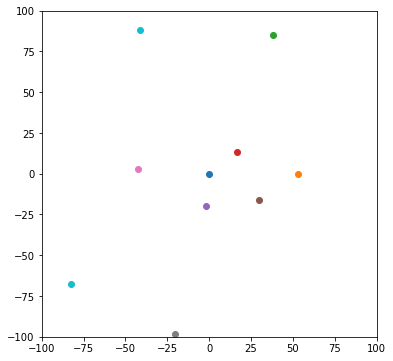

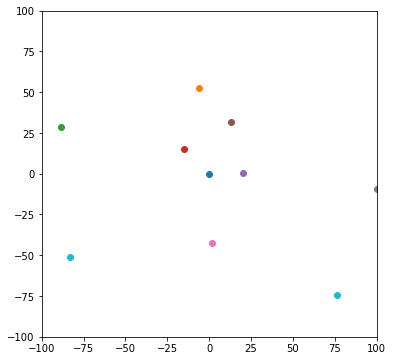

In [19]:
t = 18000
scale = 100
plt.figure(figsize=(6,6))
for i in range(num_points):
    plt.scatter(ego_points[t,i,0], ego_points[t,i,1])

s = n.nanmean(features_all[t])
plt.ylim(-scale,scale)
plt.xlim(-scale,scale)
plt.show()

plt.figure(figsize=(6,6))
for i in range(num_points):
    plt.scatter(features_all[t][i*2+1], features_all[t][i*2])

s = n.nanmean(features_all[t])
plt.ylim(-scale,scale)
plt.xlim(-scale,scale)
plt.show()

In [241]:
config = vame.init_new_project(project='single-mouse-f1', videos = ['C:/Users/Neuropixel/AH-EN/swc-en-social/vame/Female1'], 
                      working_directory='C:/Users/Neuropixel/AH-EN/swc-en-social/vame', videotype='.mp4')

Created "C:\Users\Neuropixel\AH-EN\swc-en-social\vame\single-mouse-f1-Nov20-2020\videos"
Created "C:\Users\Neuropixel\AH-EN\swc-en-social\vame\single-mouse-f1-Nov20-2020\data"
Created "C:\Users\Neuropixel\AH-EN\swc-en-social\vame\single-mouse-f1-Nov20-2020\results"
Created "C:\Users\Neuropixel\AH-EN\swc-en-social\vame\single-mouse-f1-Nov20-2020\model"
1  videos from the directory C:/Users/Neuropixel/AH-EN/swc-en-social/vame/Female1 were added to the project.
Copying the videos 

A VAME project has been created. 

Next use vame.create_trainset(config) to split your data into a train and test set. 
Afterwards you can use vame.rnn_model() to train the model on your data.


In [242]:
config

'C:\\Users\\Neuropixel\\AH-EN\\swc-en-social\\vame\\single-mouse-f1-Nov20-2020\\config.yaml'

In [238]:
ego_points.shape

(30270, 10, 2)

In [257]:
# with open(, 'w+') as f:
f = "C:\\Users\\Neuropixel\\AH-EN\\swc-en-social\\vame\\single-mouse-f1-Nov20-2020\\data\\Female1\\Female1-PE-seq.npy"
n.save(f, ego_points.reshape(-1, 20).T)

In [258]:
trainset = vame.create_trainset(config)

Creating training dataset.
Lenght of train data: 24216
Lenght of test data: 6054


In [ ]:
vame.rnn_model(config, model_name='VAME', pretrained_weights=False, pretrained_model=None)

Train RNN model!
Using CUDA
GPU active: True
GPU used: Quadro P620
Latent Dimensions: 30, Beta: 1, lr: 0.0005
Compute mean and std for temporal dataset.
Initialize train data. Datapoints 24216
Initialize test data. Datapoints 6054
Epoch: 1
Train: 
Epoch: 1.  loss: 240607.7500
Average Train loss: 45083.7238, MSE-Loss: 28401.3596, MSE-Future-Loss 16682.3641, KL-Loss: 0.0000,  Kmeans-Loss: 0.0000, weigt: 0.0000
Test: 
Average Test loss: 2242.4663, MSE-Loss: 2242.4663, KL-Loss: 0.0000, Kmeans-Loss: 0.0000
lr: 0.0005
Epoch: 2
Train: 
Epoch: 2.  loss: 20272.3301
Average Train loss: 19168.1105, MSE-Loss: 11154.4096, MSE-Future-Loss 8013.7009, KL-Loss: 0.0000,  Kmeans-Loss: 0.0000, weigt: 0.0000
Test: 
Average Test loss: 1694.9520, MSE-Loss: 1694.9520, KL-Loss: 0.0000, Kmeans-Loss: 0.0000
lr: 0.0005
Epoch: 3
Train: 
Epoch: 3.  loss: 18419.5059
Average Train loss: 15205.0624, MSE-Loss: 8588.5394, MSE-Future-Loss 6616.5230, KL-Loss: 0.0000,  Kmeans-Loss: 0.0000, weigt: 0.0000
Test: 
Average Test

Average Test loss: 480.6234, MSE-Loss: 433.5298, KL-Loss: 36.3212, Kmeans-Loss: 10.7724
lr: 0.0005
Saving model!

Epoch: 29
Train: 
Epoch: 29.  loss: 5331.4399
Average Train loss: 5378.4647, MSE-Loss: 2384.6454, MSE-Future-Loss 2938.5734, KL-Loss: 41.2276,  Kmeans-Loss: 14.0183, weigt: 1.0000
Test: 
Average Test loss: 489.5567, MSE-Loss: 441.0815, KL-Loss: 37.4461, Kmeans-Loss: 11.0291
lr: 0.0005
Epoch: 30
Train: 
Epoch: 30.  loss: 5077.9932
Average Train loss: 5236.8491, MSE-Loss: 2301.8510, MSE-Future-Loss 2879.0088, KL-Loss: 41.8048,  Kmeans-Loss: 14.1845, weigt: 1.0000
Test: 
Average Test loss: 491.8839, MSE-Loss: 443.3529, KL-Loss: 37.4714, Kmeans-Loss: 11.0595
lr: 0.0005
Epoch: 31
Train: 
Epoch: 31.  loss: 5059.1431
Average Train loss: 5132.6219, MSE-Loss: 2278.4973, MSE-Future-Loss 2797.8666, KL-Loss: 41.9854,  Kmeans-Loss: 14.2725, weigt: 1.0000
Test: 
Average Test loss: 463.1592, MSE-Loss: 413.7404, KL-Loss: 38.1983, Kmeans-Loss: 11.2205
lr: 0.0005
Saving model!

Epoch: 32
Tra